<a href="https://colab.research.google.com/github/MohammedNasserAhmed/MHIP/blob/master/MHIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **[ 1 ]  Install the required package**

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
                      "pip install sklearn",
                      "pip install scikit-learn",
                      "pip install plotly",
                      "pip install statsmodels",
                      "pip install panel",
                      "pip install colorama"
                    ]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Preparing metadata (setup.py): started
Preparing metadata (setup.py): finished with status 'error'


In [ ]:
#! pip install -U neptune


## **[ 2 ] Import GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **[ 3 ] Import the required pthon packages**

In [ ]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import panel as pn
from colorama import Fore, Style, Back
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pickle
from tabulate import tabulate
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn import tree
from sklearn import metrics
import joblib


#### **NEPTUNE panel**

In [ ]:
import neptune
from getpass import getpass


my_api_token = getpass("Enter your Neptune API token: ")

KeyboardInterrupt: ignored

In [ ]:
my_project = "mohnasgbr/Medical-Health-Insurance-Prediction"
model = neptune.init_model(key = "MOD", api_token=my_api_token, project=my_project, name='Gradient Boosting Model')
model['model/signature'].upload('/content/gbr_98__for_mhip.pkl')


In [ ]:
project = neptune.init_project(project="mohnasgbr/Medical-Health-Insurance-Prediction", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0NjgzZjIwOC1hNGZlLTQ0NTItYmEwZi01ZTk2Njg0NDIyOTcifQ==")


In [ ]:
project["general/brief"] = "https://github.com/MohammedNasserAhmed/MHIP/blob/973e8c95b916654385aff3030d4b86319242afdc/README.md"


In [ ]:
project["general/data_analysis"].upload("/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /MHIP.ipynb")


In [ ]:
run = neptune.init_run(api_token=my_api_token, project=my_project,)
run["brief"] = project["general/brief"].fetch()

In [ ]:
run.stop()

## **[ 4 ] Extra Settings**

In [ ]:
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format
pal = ['#C060A1', '#46C2CB', '#ECB365','#FF0000','#0039A6','#414A4C']
plt.rcParams['figure.figsize'] = (8, 4)

## **[ 5 ] Backup Functions**

In [ ]:
# Define CSS styling
css = """
<style>
    table {
        width: 50%;
        text-align: center;
        'font-size': '12pt';

    }
    th, td {
        padding: 8px;
        text-align:center;
    }
    th {
        background-color: lightblue;
        color: black;

    }
    td {
        text-align:center!important;
        background-color: white;
        color: black;
    }
    td::after {
			content: attr(data-value ":.2f");
            }
</style>
"""
def Display(func, index=False, cells_colors =False):
    # to remove 0's decimals and set decimals to 2 only
    func = func.applymap(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
    styled_df = HTML(css + func.to_html(index=index))
    display(styled_df)


def transform_series(data, variable, window, sigma):
    ''' Calculates the rolling average and the outliers '''
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = np.abs(residual) > std * sigma
    return avg, avg[outliers]

def get_dummies(data):
    categoricals = data.select_dtypes(include=['object']).columns
    # Loop through each categorical column and encode using factorize
    for col in categoricals:
        data[col],_ = pd.factorize(data[col])
    return data

## **[ 6 ] Dataset**

#### **Introduction**

The dataset used in this section is the insurance.csv dataset, which contains 1338 observations and 7 features. The features are:

* Independet Features :
 1. Age: Age of the customer.
 2. BMI: Body Mass Index of the individual.
 3. Children: Number of children individual has.
 4. Smoker: Is that individual a smoker or not.
 5. Region: Which region/part individual lives in.

* Dependent Feature
 6. Charges: The charges column is our target/independent feature.

The dataset contains 4 numerical features (age, BMI, children, and charges) and 3 categorical features (smoker, region, and charges). The goal is to use this dataset to predict the insurance charges of individuals.


#### **TO-DO List**

* Load the dataset
* Get the dimensionality (no. of features (columns) and observations(rows))
* DTypes and names of features
* Descriptive statistics (Max, min, mean, median and std for each continuous feature)
* Declare the target variable (feature)


#### **[ 6 : 1 ] Load the Dataset**

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /us_insurance.csv')
### Top 5 observations
print(Fore.WHITE + Back.LIGHTBLACK_EX + Style.BRIGHT + "The Top 5 oservations of Dataset : \n" + Style.RESET_ALL)
Display(df.head())
print(Fore.WHITE + Back.LIGHTBLACK_EX + Style.BRIGHT + "\n\n The Tail 5 oservations of Dataset : \n" + Style.RESET_ALL)
# Tail 5 observations
Display(df.tail())

The Top 5 oservations of Dataset : 



age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.92
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.7,0,no,northwest,21984.47
32,male,28.88,0,no,northwest,3866.86




 The Tail 5 oservations of Dataset : 



age,sex,bmi,children,smoker,region,charges
50,male,30.97,3,no,northwest,10600.55
18,female,31.92,0,no,northeast,2205.98
18,female,36.85,0,no,southeast,1629.83
21,female,25.8,0,no,southwest,2007.94
61,female,29.07,0,yes,northwest,29141.36


#### **[ 6 : 2 ] Get the dimensionality**

In [ ]:
print(Fore.BLUE + Style.BRIGHT +
      f"The no. of observations :"+
      Fore.LIGHTRED_EX +
      f"{len(df)} \n\n" +
      Fore.BLUE +
      "The no. of features :"+
      Fore.LIGHTRED_EX +
      f"{len(df.columns)}\n\n" +
      Fore.BLUE +
      "The Dataset shape is : " +
      Fore.LIGHTRED_EX +
      f"{df.shape}"
      + Style.RESET_ALL)


The no. of observations :1338 

The no. of features :7

The Dataset shape is : (1338, 7)


#### **[ 6 : 3 ] DTypes and names of features**

In [ ]:
for col in df.columns.tolist():
    print(Fore.BLUE + Style.BRIGHT +
      "The feature name and dtype | "+ Fore.GREEN + f"{col} --> {df[col].dtype}"
      + Style.RESET_ALL)

features =  [name.replace("'", "") for name in df.columns.tolist()]
cat_features = df.select_dtypes(include=['object', 'category']).columns.to_list()
num_features =  df.drop(columns=cat_features).columns.tolist()

print(Style.BRIGHT + f"\n\nThe dataset features : " +
      Fore.MAGENTA + f"{', '.join(features)} \n" +
      Fore.BLACK + "The categorical features : " +
      Fore.MAGENTA + f"{', '.join(cat_features)}"+
      Fore.BLACK + "\nThe continuous features : " +
      Fore.MAGENTA + f"{', '.join(num_features)}"+
      Style.RESET_ALL)


The feature name and dtype | age --> int64
The feature name and dtype | sex --> object
The feature name and dtype | bmi --> float64
The feature name and dtype | children --> int64
The feature name and dtype | smoker --> object
The feature name and dtype | region --> object
The feature name and dtype | charges --> float64


The dataset features : age, sex, bmi, children, smoker, region, charges 
The categorical features : sex, smoker, region
The continuous features : age, bmi, children, charges


#### **[ 6 : 4 ] Descriptive Statistics**

In [ ]:
print(Style.BRIGHT+Back.LIGHTBLACK_EX+ Fore.WHITE +
      "The Continuous Variables (features) \n" +
      Style.RESET_ALL)
Display(df.describe(), index=True)
print(Style.BRIGHT+ Fore.WHITE + Back.LIGHTBLACK_EX+
      "\nThe Categorical Variables (features) \n" +
      Style.RESET_ALL)
Display(df.describe(include="object"), index=True)

The Continuous Variables (features) 



,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.21,30.66,1.09,13270.42
std,14.05,6.1,1.21,12110.01
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9382.03
75%,51,34.69,2,16639.91
max,64,53.13,5,63770.43



The Categorical Variables (features) 



,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Zoom in on the highest and lowest charges in the dataset ⏬

In [ ]:
# Get the max min charges in the dataset
max_row_index = df['charges'].idxmax()
min_row_index = df['charges'].idxmin()

# Get both observations into a dataframe
max_min = pd.concat([df.loc[max_row_index], df.loc[min_row_index]], axis=1)

# set column headers
max_min.columns = ["The Highest Chrages","The Lowest Chrages"]

# print the row
Display(max_min, index=True)


,The Highest Chrages,The Lowest Chrages
age,54,18
sex,female,male
bmi,47.41,23.21
children,0,0
smoker,yes,no
region,southeast,southeast
charges,63770.43,1121.87


**Insights :**





You can see the notable differences in charges as well as in other features like age, BMI, and Smoker by looking at the highest and lowest table. It's still early to determine or recognize the importance of predictors. However, further analysis and research are needed to fully understand their impact on insurance charges.



The person with the highest rate of charges is a smoker, 54 years old, and has a 47 BMI ( that means he's obese; according to the World Health Organization (WHO), a BMI of less than 18.5 is considered underweight, a BMI between 18.5 and 24.9 is considered normal weight, a BMI between 25 and 29.9 is considered overweight, and a BMI of 30 or higher is considered obese), while the individual with lower insurance charges looks younger, smokes less, and has a healthier lifestyle overall.

#### **[ 6 : 5 ] Declare the target variable (feature)**

***Target Variable*** : is the variable that the model is trying to predict or estimate. It is also known as the dependent variable or response variable. In regression models like this, the target variable is typically a continuous variable, such as a numeric value or a real number, and the goal is to find a relationship between the target variable and one or more predictor variables, also known as independent variables or features.

***The purpose of model*** is to predict the insurance ***chrages*** (target variable) by using some predictor variables *( age, sex, bmi, children, smoker, region )*

In [ ]:
charges_stats = df['charges'].agg(['max', 'min', 'mean']).apply(lambda x: '{:.2f}'.format(x))

print(Style.BRIGHT + f"\nThe maximum Charges : " +
      Fore.GREEN + f"{charges_stats[0]} $" +
      Fore.BLACK + "\n\nThe minimum Charges : " +
      Fore.MAGENTA + f"{charges_stats[1]} $"+
      Fore.BLACK + "\n\nThe average of Charges : " +
      Fore.RED + f"{charges_stats[2]} $"+
      Style.RESET_ALL)


The maximum Charges : 63770.43 $

The minimum Charges : 1121.87 $

The average of Charges : 13270.42 $


## **[ 7 ] Expolatory Data Analysis (EDA)**


EDA is an essential step in regression modeling that involves understanding the distribution of variables and identifying relationships. Various visualization libraries like seaborn, matplotlib, and plotly are used to create different plots and graphs to gain insights into the datase . Some significant questions to ask and answer during the EDA process for a health insurance prediction project with the given dataset include:

1. What is the distribution of the target variable (charges)?

2. What is the distribution of each attribute in the dataset, including age, sex, BMI, children, region, and smoker status?

3. Are there any missing or null values in the dataset? If so, how are they distributed across the attributes?

4. What is the correlation between each attribute and the target variable (charges)? Which attributes have the strongest correlation with the target variable?

5. Are there any significant differences in the distribution and correlation of the attributes based on different categories or subgroups (e.g., age, sex, smoker status, region)?

6. Are there any outliers in the dataset? If so, how do they affect the distribution and correlation of the attributes?

7. What insights can be gained from visualizing the data using scatter plots, histograms, box plots, and other visualization techniques?

8. Are there any significant interactions between the attributes that affect the prediction of the target variable?

Answering these questions can help to identify patterns, trends, and relationships in the data, and can provide valuable insights for feature engineering and model selection.

#### **[7 : 1] Distribuation of Target Variable (chargs)**

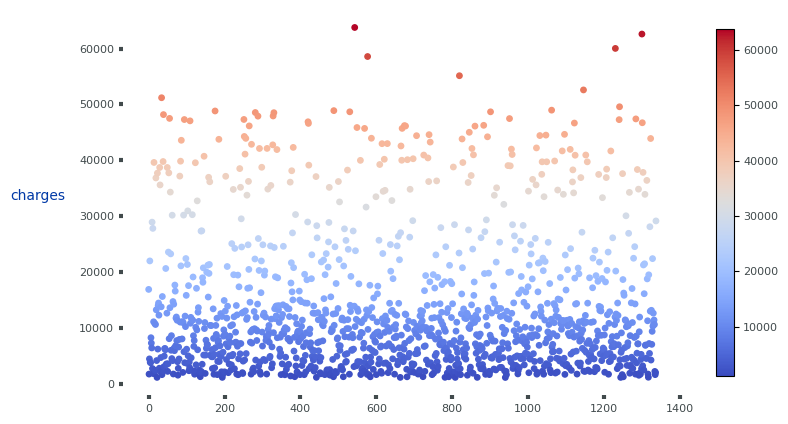

In [ ]:
plt.figure(figsize=(9, 5))
plt.scatter(df.index, df['charges'], c = df['charges'], cmap='coolwarm', s=15)
cbar = plt.colorbar(pad=0.05,shrink=0.9)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(8)
     t.set_color("#414A4C")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('charges', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.show()

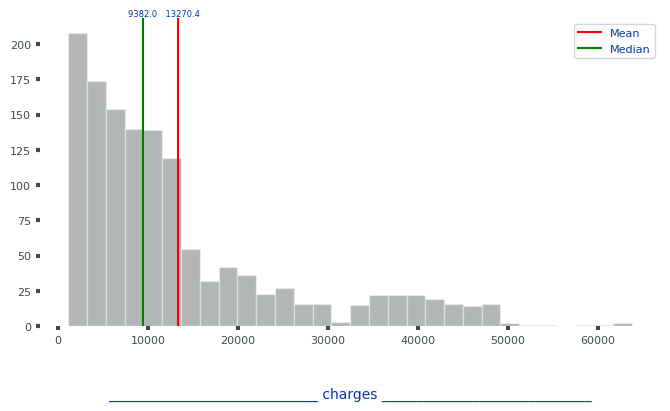

In [ ]:
plt.rcParams['font.size'] = 8
plt.rcParams['text.color'] = '#0039A6'
plt.figure(figsize=(8, 4))
sns.distplot(df['charges'], kde=False,color='#414A4C', hist_kws={'edgecolor': 'white'})
plt.axvline(x=np.mean(df['charges']), color = 'red', label='Mean',)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"    {np.mean(df['charges']):.1f}", ha='center', va='bottom', size=6)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"{np.median(df['charges']):.1f}        ", ha='right', va='bottom', size=6)

plt.axvline(x=np.median(df['charges']), color = 'green', label='Median')
plt.legend(loc="upper right")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_xlabel('______________________________ charges ______________________________', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
plt.show()

#### **[ 7 : 2 ] Target Variable Vs. Independent Variables**

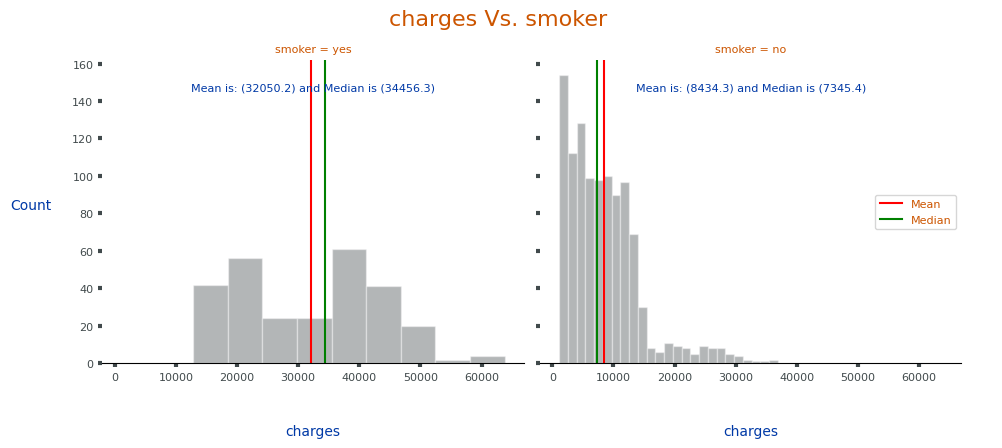

In [ ]:
plt.rcParams['font.size'] = 8
plt.rcParams['text.color'] = '#CC5500'
def create_plot(data, var_1="smoker", var_2 = "charges", metrics=True, metrics_size= 8):

    g = sns.FacetGrid(data, col=var_1)

    g.add_legend()
    g.legend.get_title().set_fontsize(30)
    g.fig.set_size_inches(10, 4.5)

    g.fig.suptitle(f'{var_2} Vs. {var_1}', fontsize=16, color ="#CC5500")

    for ax in g.axes.flat:
        ax.set_xlabel(var_2, fontsize=10, color='#0039A6', labelpad=30)
        ax.set_ylabel('Count', fontsize=10, color='#0039A6', rotation = 360, labelpad=30)
        ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    g.map(sns.distplot, var_2, color='#414A4C', kde=False,hist_kws={'edgecolor': 'white'})

    if metrics == True:
        for category, ax in g.axes_dict.items():
            # Get the count of each level
            mean = df[df[var_1] == category][var_2].mean()
            median = df[df[var_1] == category][var_2].median()
            ax.axvline(x=mean, color = 'red', label='Mean')
            ax.axvline(x=median, color = 'green', label='Median')

            ax.text(0.5, 0.9, f"Mean is: ({mean :.1f}) and Median is ({median :.1f})",
                transform=ax.transAxes, ha='center', color="#0039A6", size = metrics_size)
        plt.legend(loc="center right")
    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)

    return  plt.show()
create_plot(df)

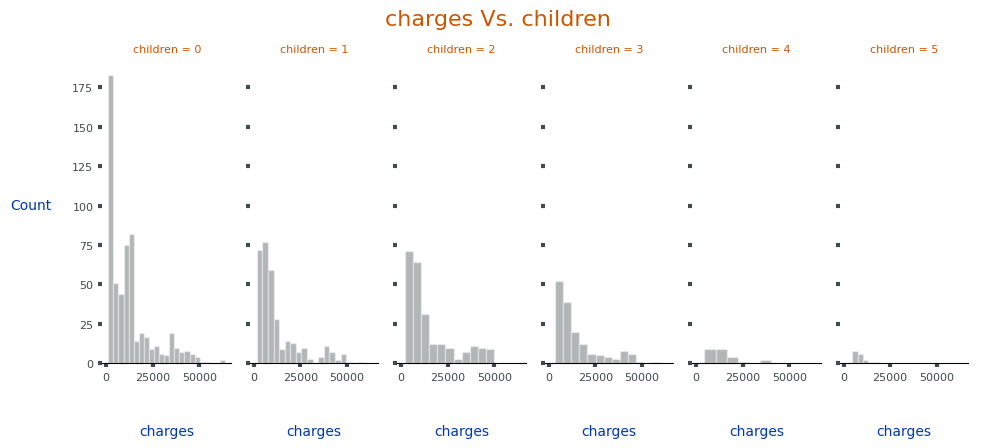

In [ ]:
create_plot(data=df,var_1='children', metrics = False, metrics_size = 4)

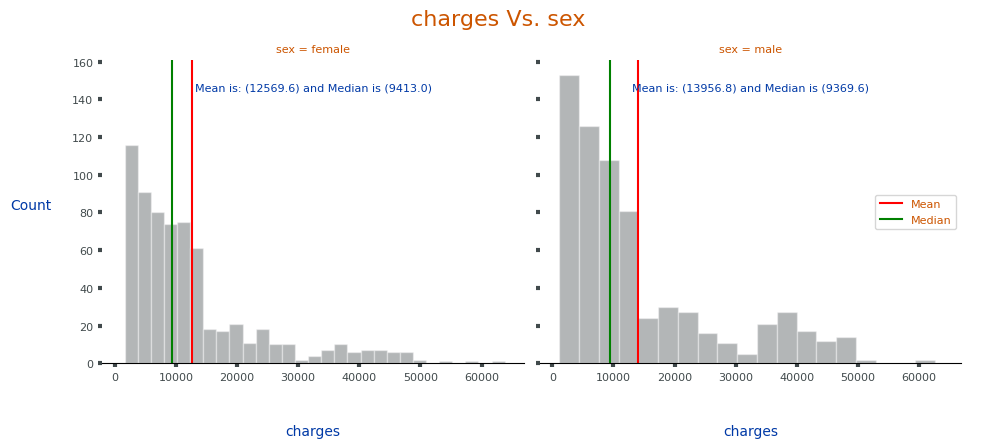

In [ ]:
create_plot(data=df,var_1='sex', metrics = True)

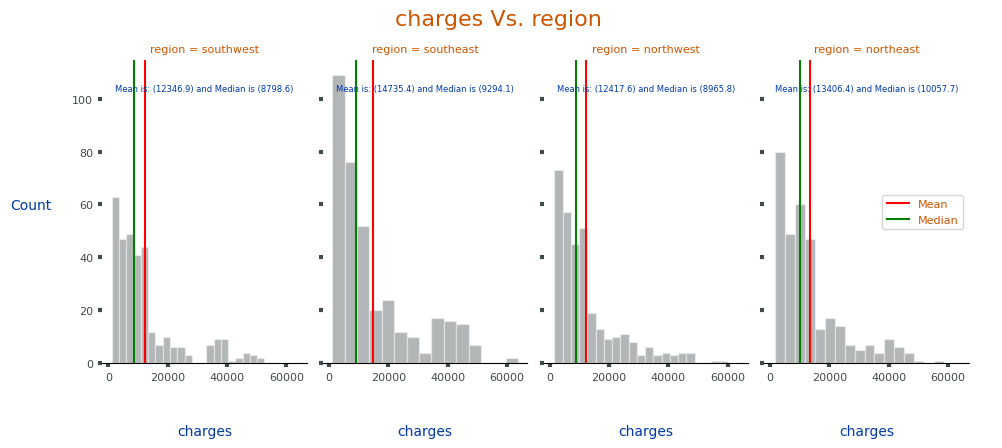

In [ ]:
create_plot(data=df,var_1='region', metrics = True, metrics_size=6)

In [ ]:
def bivariate_plot(data, hue, var):
    g = sns.FacetGrid(data, hue=hue, palette=pal,hue_kws={'marker': ['o', 's', 'D','v','^','*']}, height=5)
    g.fig.set_size_inches(8, 5)
    g.fig.suptitle(f'Charges Vs. {var} Vs. {hue}', fontsize=12, color = "#C70039") # "#C70039""#CC5500"
    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel(var, fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
        ax.set_xlabel('charges', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
        ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    g.map(sns.scatterplot, "charges", var, s=50, alpha=.7)
    g.add_legend()
    plt.show()

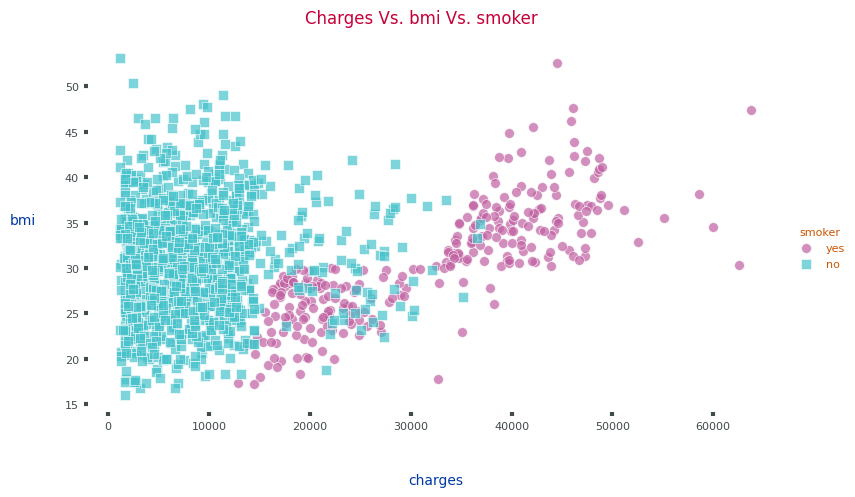

In [ ]:
bivariate_plot(df, hue='smoker', var = "bmi")

In [ ]:
def barplot(data, var, hue):
    plt.rcParams['font.size'] = 8

    g = sns.barplot(data = data, x = var, y = 'charges', hue = hue, palette =pal, width=0.6)
    #g.fig.suptitle()
    g.set_title(f' charges Vs. {var}  (Hue : {hue})', fontsize=12, color ="#C70039",  y=1.1) #C70039
    fig = plt.gcf()

    ax = plt.gca()
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.1, 0.9))
    fig.set_figwidth(8)
    fig.set_figheight(4)
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel("charges", fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
    ax.set_xlabel(var, fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
    ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    v = 0
    h = 0
    for i,p in enumerate(ax.patches):
        cat = df[df[var] == df[var].unique().tolist()[v]][hue].value_counts()[h]
        total = len(df[df[var] == df[var].unique().tolist()[v]])
        precentage = "{:.2f} %".format((100 * cat)/total)
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,  height + 0.1 * height, precentage, ha="center",fontsize=6, color ='#0039A6')
        v+=1
        if v >= df[var].nunique():
            v=0
            h+=1


    plt.setp(ax.get_legend().get_texts(), fontsize='6', fontweight='bold', color="#0039A6")
    plt.setp(ax.get_legend().get_title(), fontsize='8',  color="#C70039")
    plt.show()
    plt.show()


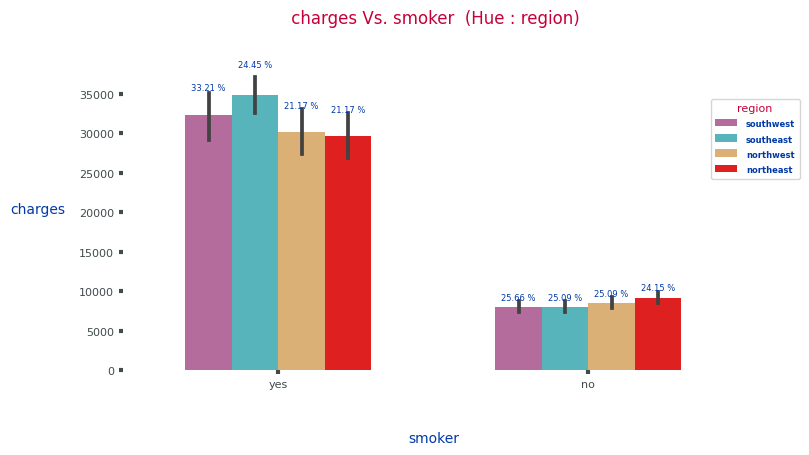

In [ ]:
barplot(df, "smoker","region")

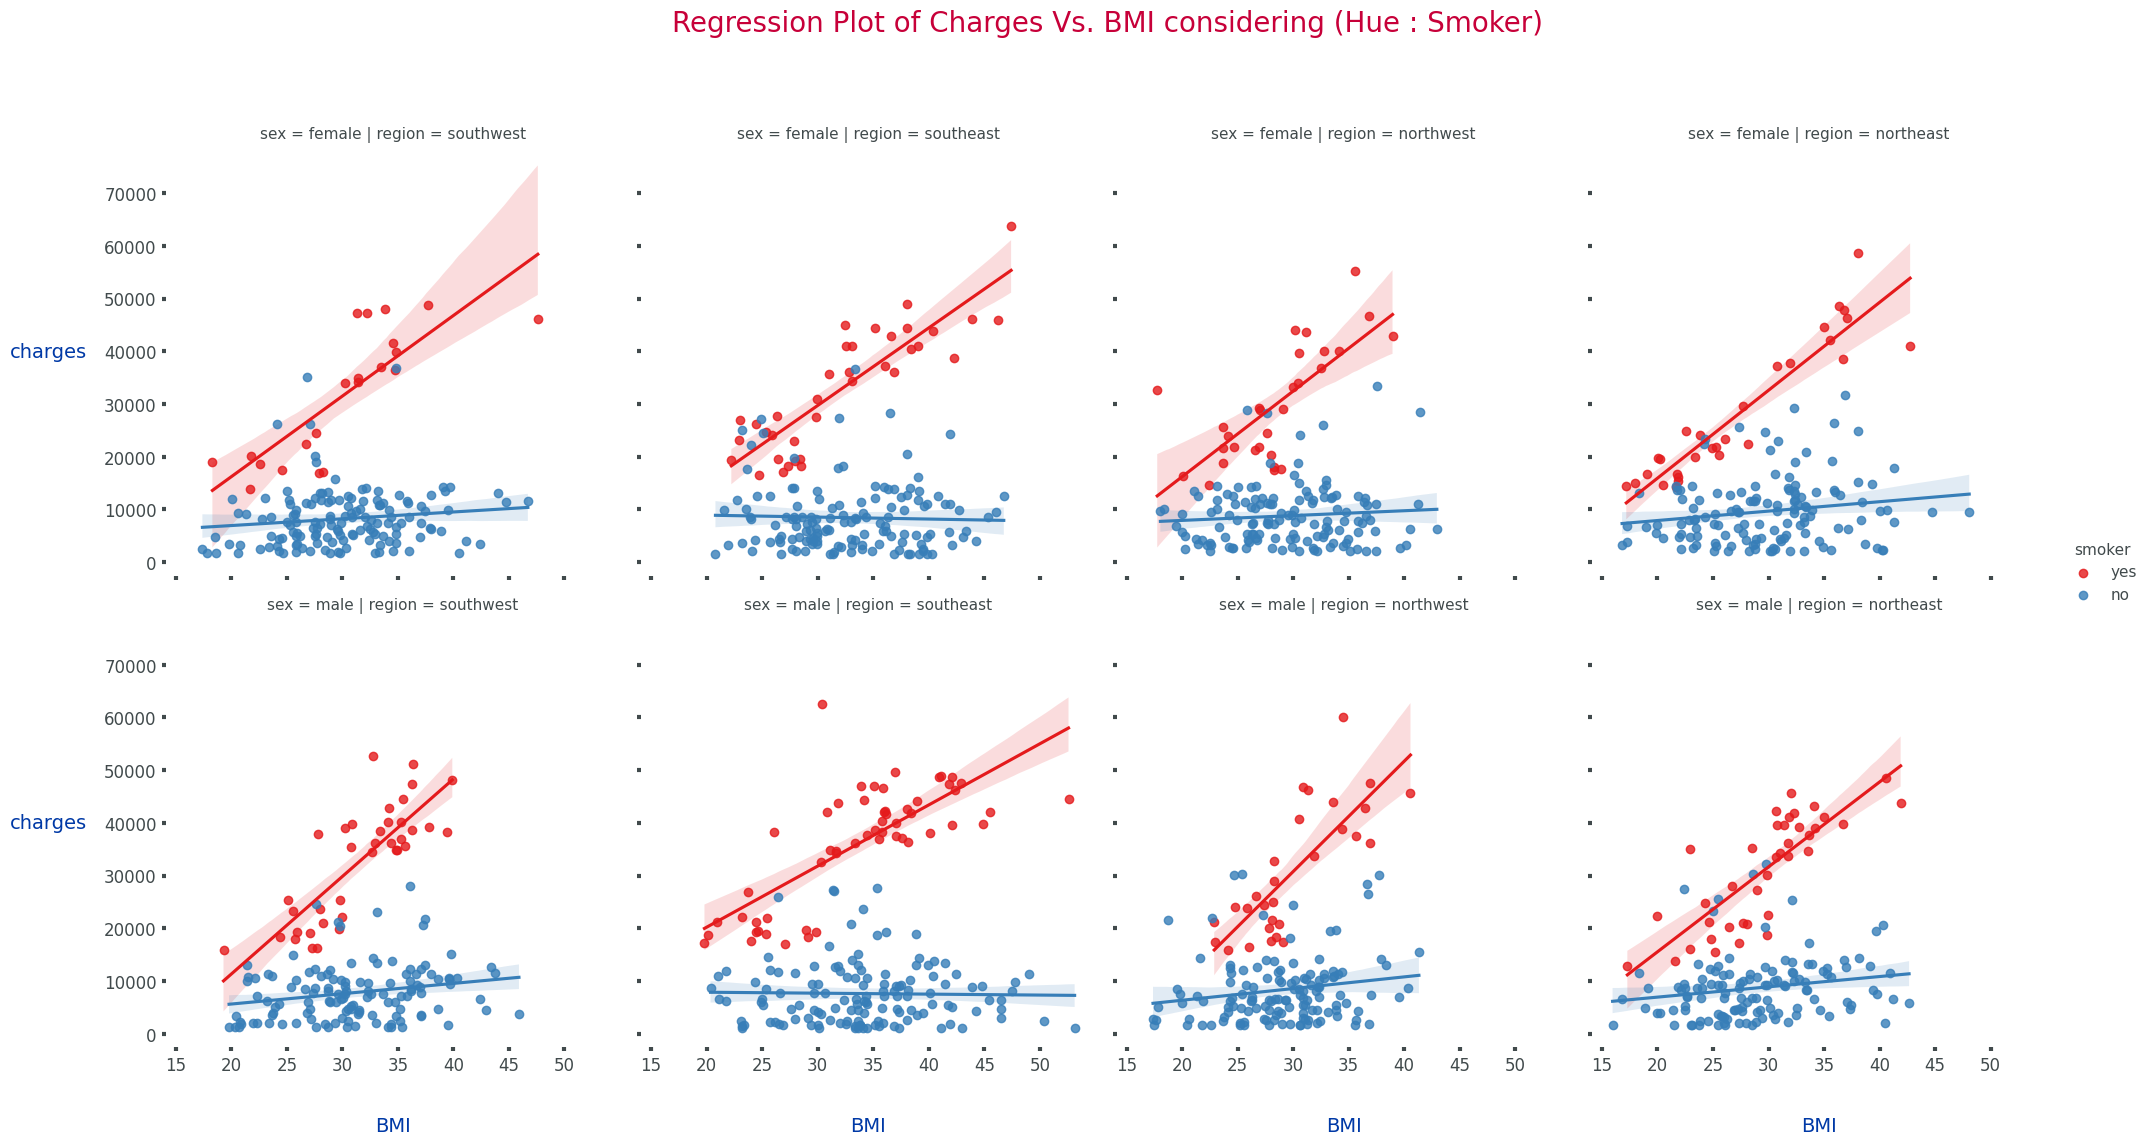

In [ ]:
#regression plot to understand the relationship between the bmi and charges considering
plt.rcParams['font.size'] = 11
plt.rcParams['text.color'] = "#414A4C"
g = sns.lmplot(x = "bmi", y = "charges", row = "sex", col = "region", hue = 'smoker', data = df, palette="Set1")
g.fig.suptitle(f'Regression Plot of Charges Vs. BMI considering (Hue : Smoker)', fontsize=20, color ="#C70039",  y=1.1)

for ax in g.axes.flat:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel("charges", fontsize=14, rotation=360, labelpad=40, color = "#0039A6")
    ax.set_xlabel('BMI', fontsize=14, rotation=360, labelpad=30, color = "#0039A6")
    ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=12)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=12)
plt.show()

#### **PANEL Board**

In [ ]:
#pn.extension(sizing_mode="stretch_width", design='material', template="fast")
#variable_widget_1 = pn.widgets.Select(name="categorical variables", value="smoker", options=df.select_dtypes(include=['object', 'category']).columns.to_list())
#variable_widget_2 = pn.widgets.Select(name="continous variables", value="charges", options=df.select_dtypes(exclude=['object', 'category']).columns.to_list())
#bound_plot = pn.bind(create_plot,data=df, var_1=variable_widget_1, var_2=variable_widget_2)


In [ ]:
#app = pn.Column(variable_widget_1, variable_widget_2, bound_plot)
#app

#### **[ 7 : 3 ] Data Preparation and Cleansing**

**8-Step checklist**

* Missing Values :
* Dublicate and Low Variation Data
* Incorrect and Irrelevant Data
* Categorical Data
* Outliers
* Feature Scaling
* Feature Selection
* Validation Split

**Missing Values**

In [ ]:
# check per total dataset
print(Style.BRIGHT +
      "Any NULL values : " +
      Fore.BLUE +
      f"{df.isnull().values.any()}\n" +
      Style.RESET_ALL)

# Check per column
print(Style.BRIGHT +
      "NULL values per feature \n" +
      Fore.GREEN +
      f"{df.isnull().sum().astype(int).to_string(index=True, header=False)} \n"+
      Style.RESET_ALL)

Any NULL values : False

NULL values per feature 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0 



***Insights*** : No missing values in the dataset

**Dublicated Data**

In [ ]:
# Detect dublicated data
dups = df.duplicated()
print(dups.any())
Display(df[dups], index=True)

# drop the dublicated observations
df = df.drop(581, axis=0)
df = df.reset_index(drop=True)

True


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.56


***Insights*** : It can be seen that there is no duplicated data in the dataset except for a single observation. and in our case, the similarity may happen during the data collection process. There are no identical features here, just age, region, smoking habit, sex, and children. However, it is important to note that even though there are no identical features, the presence of observations with duplicated data can still affect the accuracy and reliability of the analysis. Since we're dealing with only one observation, we are fine to proceed with our analysis without any concerns.

**Incorrect and Irrelevant Data**

*Anomaly Detection Algorithms* :

 Isolation Forest model represents the anomaly score assigned to each data point in your dataset. Anomaly scores indicate how likely a data point is to be an outlier or anomaly. In the Isolation Forest algorithm, lower anomaly scores indicate a higher likelihood of being an anomaly. Anomaly scores usually range between -1 and 1, where values closer to -1 are considered more anomalous.

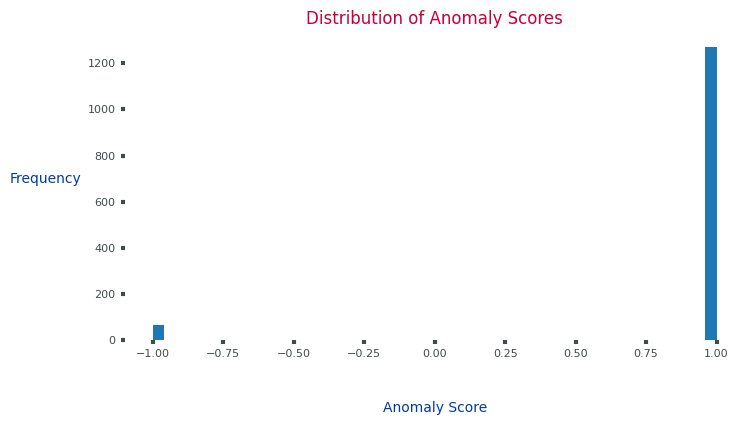

In [ ]:
iso_ds = df.drop('region', axis=1).copy()

iso_ds = get_dummies(iso_ds)

iso_forest = IsolationForest(contamination=0.05)
anomaly_scores = iso_forest.fit_predict(iso_ds)

# Convert anomaly_scores to a Series
anomaly_scores_series = pd.Series(anomaly_scores, index=df.index)

# Filter out anomalies (rows with negative anomaly scores)
filtered_df = df[anomaly_scores_series >= 0]
filtered_df = filtered_df.reset_index(drop=True)

plt.hist(anomaly_scores, bins=50)
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('Frequency', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.set_xlabel('Anomaly Score', fontsize=10, rotation=0, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.title('Distribution of Anomaly Scores', fontsize=12, color ="#C70039")
plt.show()

***insights*** :  The dataset appears to contain some anomalies that need additional investigation or may even need to be removed, according to the anomaly detection algorithm discussed above. These anomalies could potentially affect the accuracy and reliability of any analysis or predictions made using the dataset. It is crucial to identify the cause of these anomalies and determine whether they are due to errors in data collection, measurement, or other factors before taking any further action. but we have no way to identify the cause, so the anomalous data points will be dropped from the dataset.

**Categorical Data**

In [ ]:
# Get percentages of Categorical variables
for col in cat_features:
    Display(pd.DataFrame((df[col].value_counts(normalize=True) * 100).apply(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') + " %")), index=True)

,sex
male,50.49 %
female,49.51 %


,smoker
no,79.51 %
yes,20.49 %


,region
southeast,27.23 %
southwest,24.31 %
northwest,24.23 %
northeast,24.23 %


In [ ]:
# Count observations per level for all categoricl features
for col in cat_features:
    Display(pd.DataFrame(pd.crosstab(index=df[col],columns = "freq").rename_axis(None, axis=1)), index=True)

,freq
sex,
female,662
male,675


,freq
smoker,
no,1063
yes,274


,freq
region,
northeast,324
northwest,324
southeast,364
southwest,325


***Insights*** : You can see that there are three categorical features in the dataset, which include sex (male or female), smoker (yes or no), and region (southeast, southwest, northeast, northwest). The male category in sex feature is top with 50.52% (676 males), the positive-smokers category is top with 79.52% (1067 positive-smokers), which looks imbalanced and may require more attention during analsis, and the southeast region is top with 27.2% (regions have roughly equal distributions as follows: southeast (27.20%), southwest (24.29%), northwest (24.29%), and northeast (24.20%)). These categorical features provide valuable insights into the demographics and lifestyle choices of the individuals in the dataset, allowing for further analysis and understanding of potential factors influencing insurance charges.

**Outliers**

*USING : Isolation Forest & Local Outlier Factor*

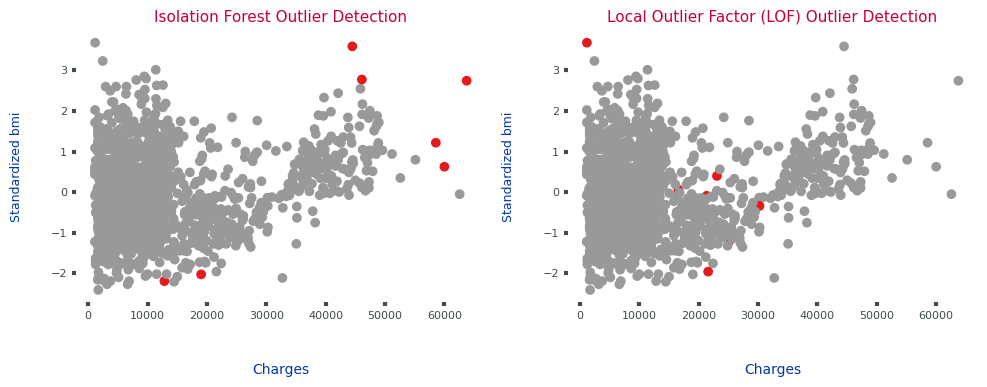

In [ ]:
# Extract the charges column (target variable)
charges = iso_ds['charges'].values.reshape(-1, 1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(iso_ds)

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.005)
iso_preds = iso_forest.fit_predict(X_scaled)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(contamination=0.005)
lof_preds = lof.fit_predict(X_scaled)

# Visualize the results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(charges, X_scaled[:, 2], c=iso_preds, cmap='Set1')
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('Standardized bmi', fontsize=9, labelpad=20, color = "#0039A6")
ax.set_xlabel('Charges', fontsize=10, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.title('Isolation Forest Outlier Detection', fontsize=11, color='#C70039')

plt.subplot(1, 2, 2)
plt.scatter(charges, X_scaled[:, 2], c=lof_preds, cmap='Set1')
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('Standardized bmi', fontsize=9, labelpad=20, color = "#0039A6")
ax.set_xlabel('Charges', fontsize=10, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.title('Local Outlier Factor (LOF) Outlier Detection', fontsize=11, color='#C70039') #4D3C77", "#C70039

plt.tight_layout()
plt.show()


In [ ]:
# Return outlier observations using Isolation Forest
iso_outliers = iso_ds[iso_preds == -1]
print("Outliers detected by Isolation Forest:")
Display(iso_outliers, index=True)

# Return outlier observations using LOF
lof_outliers = iso_ds[lof_preds == -1]
display("Outliers detected by Local Outlier Factor:")
Display(lof_outliers, index=True)

Outliers detected by Isolation Forest:


,age,sex,bmi,children,smoker,charges
250,18,1,17.29,2,0,12829.46
543,54,0,47.41,0,0,63770.43
577,31,0,38.09,1,0,58571.07
859,37,0,47.6,2,0,46113.51
1046,22,1,52.58,1,0,44501.4
1084,39,0,18.3,5,0,19023.26
1229,52,1,34.48,3,0,60021.4


'Outliers detected by Local Outlier Factor:'

,age,sex,bmi,children,smoker,charges
102,18,0,30.11,0,1,21344.85
115,60,1,28.59,0,1,30260
219,24,0,23.21,0,1,25081.77
397,21,1,31.02,0,1,16586.5
430,19,1,33.1,0,1,23082.96
1026,23,1,18.71,0,1,21595.38
1316,18,1,53.13,0,1,1163.46


In [ ]:
data_cleaned_iso = iso_ds[iso_preds == 1]

# Remove outliers detected by Local Outlier Factor
data_cleaned_lof = iso_ds[lof_preds == 1]

print("Original Data before removing outliers:")
Display(df.describe(), index=True)

print("\n\nCleaned Data after removing Isolation Forest outliers:")
Display(data_cleaned_iso[num_features].describe(), index=True)

print("\n\nCleaned Data after removing Local Outlier Factor outliers:")
Display(data_cleaned_lof[num_features].describe(), index=True)



Original Data before removing outliers:


,age,bmi,children,charges
count,1337,1337,1337,1337
mean,39.22,30.66,1.1,13279.12
std,14.04,6.1,1.21,12110.36
min,18,15.96,0,1121.87
25%,27,26.29,0,4746.34
50%,39,30.4,1,9386.16
75%,51,34.7,2,16657.72
max,64,53.13,5,63770.43




Cleaned Data after removing Isolation Forest outliers:


,age,bmi,children,charges
count,1330,1330,1330,1330
mean,39.24,30.63,1.09,13119.82
std,14.05,6.03,1.2,11863.07
min,18,15.96,0,1121.87
25%,27,26.3,0,4724.37
50%,39,30.33,1,9303.3
75%,51,34.6,2,16443.29
max,64,53.13,5,62592.87




Cleaned Data after removing Local Outlier Factor outliers:


,age,bmi,children,charges
count,1330,1330,1330,1330
mean,39.29,30.66,1.1,13244.41
std,14.01,6.07,1.21,12116.86
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9333.01
75%,51,34.7,2,16443.29
max,64,52.58,5,63770.43


***Insights*** : Taking a closer look at the chart and statistical tables above, it looks like LOF and ISO outlier detectors are not performing as well as they should, as they have a high rate of false positives. This indicates that these detectors are incorrectly identifying a significant number of data points as outliers when they are actually not. It is important to consider alternative outlier detection methods that can provide more accurate results in our specific case. Additionally, further analysis and evaluation of the data may be required to understand the underlying factors contributing to these false positives and refine our outlier detection approach accordingly.

*USING : TensorFlow  AutoEncoder*

In [ ]:
df.drop('region', axis=1, inplace=True)

In [ ]:
#drop region feature
# Standardize the features
tfae_df = df.copy()
tfae_df = get_dummies(tfae_df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfae_df)

# Build and train autoencoder for outlier detection
input_dim = X_scaled.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Define a threshold for outlier detection
threshold = np.percentile(reconstruction_errors, 90)

# Identify and remove outliers
outlier_indices = np.where(reconstruction_errors > threshold)[0]
data_cleaned_autoencoder = df.drop(outlier_indices)
data_cleaned_autoencoder = data_cleaned_autoencoder.reset_index(drop=True)

display("Original Data before removing outliers:")
Display(df.describe(), index=True)

display("Cleaned Data after removing Autoencoder outliers:")
Display(data_cleaned_autoencoder[num_features].describe(), index=True)



42/42 [==============================] - 0s 2ms/step


'Original Data before removing outliers:'

,age,bmi,children,charges
count,1337,1337,1337,1337
mean,39.22,30.66,1.1,13279.12
std,14.04,6.1,1.21,12110.36
min,18,15.96,0,1121.87
25%,27,26.29,0,4746.34
50%,39,30.4,1,9386.16
75%,51,34.7,2,16657.72
max,64,53.13,5,63770.43


'Cleaned Data after removing Autoencoder outliers:'

,age,bmi,children,charges
count,1203,1203,1203,1203
mean,39.25,30.9,1.14,12245.21
std,13.86,5.78,1.19,11256.19
min,18,16.82,0,1121.87
25%,27,26.7,0,4567.8
50%,39,30.59,1,8627.54
75%,51,34.77,2,13978.15
max,64,52.58,5,52590.83


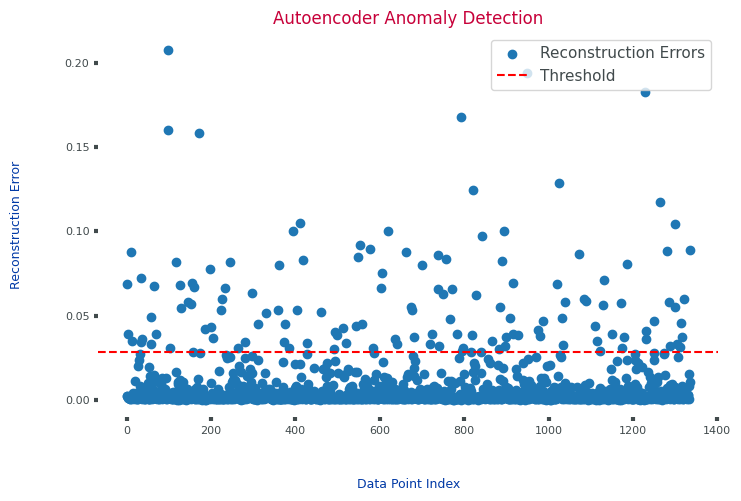

In [ ]:
# Plot reconstruction errors
plt.figure(figsize=(8, 5))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, cmap='Set1', marker='o', label='Reconstruction Errors')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('Reconstruction Error', fontsize=9, labelpad=30, color = "#0039A6")
ax.set_xlabel('Data Point Index', fontsize=9, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.title('Autoencoder Anomaly Detection', fontsize=12, color = "#C70039") #"#4D3C77", "#C70039"
plt.legend(loc='upper right')
plt.show()


**Feature Scaling**

✅ *Feature scaling* :

is an important step in the Exploratory Data Analysis (EDA) process, especially when working with machine learning algorithms that are sensitive to the scale of input features. In our case, we have a Medical Health Insurance dataset with predictors like age, BMI, sex, smoker, region, and children. Let's go through the feature scaling process and how it can be applied to our dataset:

Feature scaling is the process of standardizing the range of independent variables or features of the dataset. This is important because some machine learning algorithms, like gradient descent-based optimization, are sensitive to the scale of input features. Features with larger scales might dominate the learning process, leading to biased results.

**Feature Selection**

*USING ✴ Correlation with Random Forest Regressor*

In [ ]:
# Separate features and target
X = iso_ds.drop('charges', axis=1)
y = iso_ds['charges']

# Calculate feature correlation with target
correlation = X.corrwith(y)

# Display correlation values
print(correlation)

# Train a Random Forest model for feature importance
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importances
print(feature_importances)


age         0.30
sex         0.06
bmi         0.20
children    0.07
smoker     -0.79
dtype: float64
[0.12926195 0.00591008 0.22407566 0.0196229  0.62112941]


*USING ✴ Correlation with heatmap*

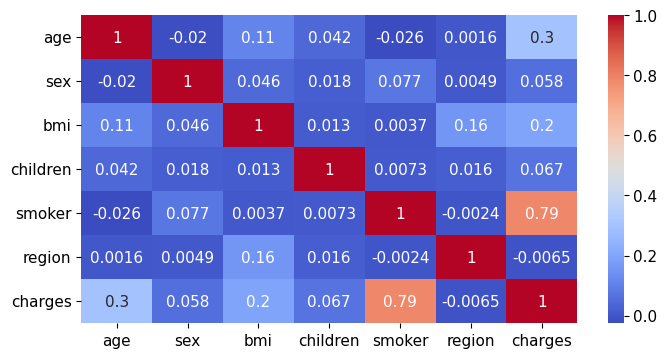

In [ ]:
plt.figure(figsize=(8,4))
sns.heatmap(ds.corr(),cmap='coolwarm',annot=True)
plt.show()

***Insights***  ⏰   It looks like the target feature (charges) has a high correlation with the smoker feature in the US Medical Health Insurance Dataset and a low correlation with age and BMI features. This points out that smoking has the potential to be a significant factor in the underlying use case with a scale of 0.79, while age and BMI come next in terms of their impact on the target feature with a scale of 0.3 and 0.2, respectively. Other features like sex, children, and region have no detectable correlation with the target feature. These findings indicate that smoking has a strong influence on the charges. Age and BMI also have some influence, although to a lesser extent. However, factors such as sex, number of children, and region do not seem to have any noticeable impact on the target feature.

**Normalize and Split Data**

In [ ]:
def split(data, log = False):
    X = data.drop('charges', axis=1)
    if log:
        y = np.log10(data['charges'])
    else:
        y = data['charges']

    # Split features into numerical and categorical
    data_num = X[['age', 'bmi', 'children']]  # Numerical variables
    data_cat = X.drop(['age', 'bmi', 'children'], axis=1)  # Categorical variables

    # Scaling numerical variables
    scaler = StandardScaler()
    df_num_scaled = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)

    # One-hot encoding categorical variables
    encoder = OneHotEncoder(drop='first', sparse=False)
    data_cat_encoded = encoder.fit_transform(data_cat)
    df_cat_encoded = pd.DataFrame(data_cat_encoded, columns=encoder.get_feature_names_out(data_cat.columns))
    # Concatenate numerical and encoded categorical features
    X = pd.concat([df_num_scaled, df_cat_encoded], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return scaler, X, y, X_train, X_test, y_train, y_test

In [ ]:
scaler, X, y, X_train, X_test, y_train, y_test = split(data_cleaned_autoencoder)
print(X_train.shape, y_train.shape,
      X_test.shape, y_test.shape)


(962, 5) (962,) (241, 5) (241,)


## **[ 8 ] Models**

In [ ]:
#OLS Regression
x2 = sm.add_constant(np.asarray(X_train))
#fit linear regression model
model = sm.OLS(y_train, x2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     621.5
Date:                Sat, 02 Sep 2023   Prob (F-statistic):          2.12e-297
Time:                        15:48:47   Log-Likelihood:                -9645.5
No. Observations:                 962   AIC:                         1.930e+04
Df Residuals:                     956   BIC:                         1.933e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8596.1833    258.446     33.261      0.000    8088.996    9103.371
x1          3865.8640    179.749     21.507      0.000    3513.116    4218.612
x2          1445.4702    181.967      7.944      0.000    1088.369    1802.572
x3            56.8336    178.137      0.319      0.750    -292.752     406.419
x4          -533.4266    356.258     -1.497      0.135   -1232.565     165.712
x5          2.468e+04    486.318     50.759      0.000    2.37e+04    2.56e+04
==============================================================================
Omnibus:                      237.812   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              665.361
Skew:                           1.246   Prob(JB):                    3.30e-145
Kurtosis:                       6.223   Cond. No.                         3.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Feature Importance**

0.9776638300305837


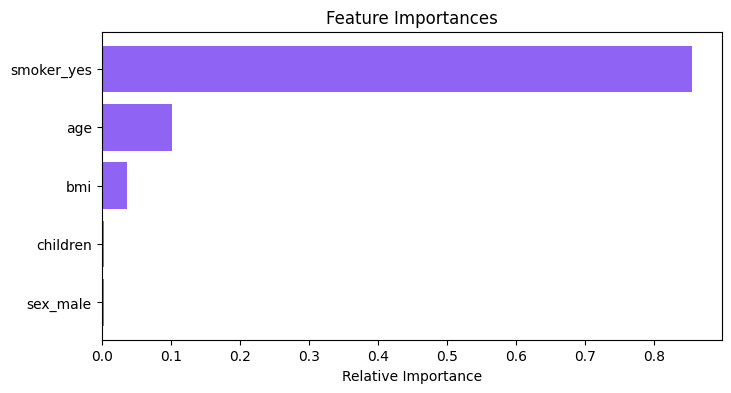

In [ ]:
# Random Forest
model = RandomForestRegressor(n_estimators=100, criterion='squared_error',
min_samples_split=2)
# fit the regressor model
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

# Important Features
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4',
align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()


+-----------------------------+----------+
|            Model            | Accuracy |
+-----------------------------+----------+
| Gradient Boosting Regressor |   0.81   |
|   Random Forest Regressor   |   0.80   |
|      Bagging Regressor      |   0.78   |
|        XGB Regressor        |   0.76   |
|     Ada Boost Regressor     |   0.75   |
+-----------------------------+----------+


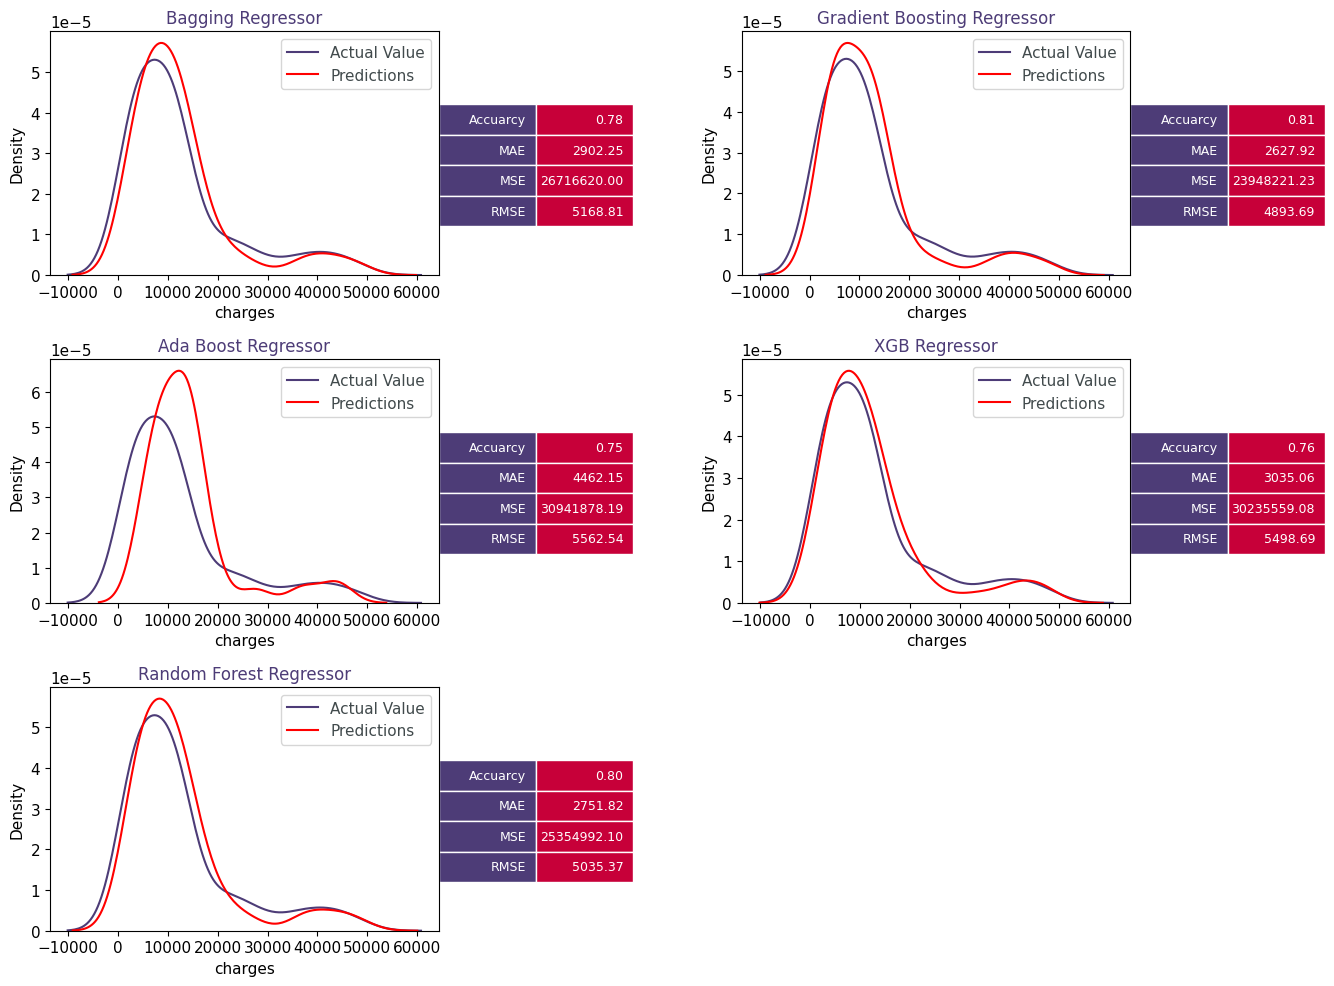

In [ ]:
models = [
    ("Bagging Regressor", BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))),
    ("Gradient Boosting Regressor",GradientBoostingRegressor()),
    ("Ada Boost Regressor",AdaBoostRegressor()),
    ("XGB Regressor",xgb.XGBRegressor()),
    ("Random Forest Regressor",RandomForestRegressor(n_estimators=100, criterion='squared_error',
min_samples_split=2))



    # Add more models here
]

# Train and evaluate models
results, preds = [], []
for model_name, model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test,y_test)
    predictions = model.predict(X_test)
    #accuracy = accuracy_score(y_test, predictions)
    preds.append([model_name,model, "{:.2f}".format(accuracy), predictions])
    results.append([model_name, "{:.2f}".format(accuracy)])
results = sorted(results, key=lambda x: x[1], reverse=True)
# Display results in a table
table_headers = ["Model", "Accuracy"]
table = tabulate(results, headers=table_headers, tablefmt="pretty")
print(table)


num_plots = len(models)
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))

# Create subplots grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 10))

# Plot predictions using subplots
for i, (model_name, model,accuracy, predictions) in enumerate(preds):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.distplot(y_test, hist=False, color="#4D3C77", label="Actual Value", ax=ax)
    sns.distplot(predictions, hist=False, color=pal[3], label="Predictions" , ax=ax)
    mae = '{:.2f}'.format(metrics.mean_absolute_error(y_test, predictions))
    mse = '{:.2f}'.format(metrics.mean_squared_error(y_test, predictions))
    rmse = '{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    ax.set_title(f"{model_name}", fontsize=12, color = "#4D3C77")
    data = [['Accuarcy', accuracy], ['MAE', mae], ['MSE', mse],["RMSE", rmse]]
    table = ax.table(cellText=data,edges='closed', bbox=[1,0.2,0.5,0.5], cellColours=[["#4D3C77", "#C70039"], ["#4D3C77", "#C70039"], ["#4D3C77", "#C70039"], ["#4D3C77", "#C70039"]])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    table.get_tightbbox()
    for cell in table.get_celld().values():
        cell.get_text().set_color('white')
        cell.set_edgecolor('white')
    #ax.axis('off')
    ax.legend()

# Remove empty subplots
for i in range(len(models), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('models.png')
plt.show()

In [ ]:
# save the iris classification model as a pickle file
#model_pkl_file = "gbr__for_mhip_98.pkl"

#with open(model_pkl_file, 'wb') as file:
#    pickle.dump(model, file)

In [ ]:
#joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

**Pass new data**

In [ ]:
def scale_data(values):
    column_names = ['age', 'bmi', 'children', 'sex', 'smoker']

    # Create a dictionary to map column names to list elements
    data = dict(zip(column_names, values))
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame([data])
    df.iloc[:,:3]=scaler.transform(df.iloc[:,:3])
    format_function = lambda x: f'{x:.2f}'

    # Apply the formatting function to all values in the DataFrame
    df = df.applymap(format_function)
    return df

# Load the saved model
model = joblib.load('/content/rfr__for_mhip_98.pkl')
scaler = joblib.load('/content/scaler.pkl')
data = scale_data([20,30.5,2,0,1])
# Make predictions on new_data
charges = model.predict(data.values)
charges[0]

35414.385096

⚓


### **Key Insights**
1. Feature Importance: After analyzing the dataset, we found that the most influential factors
affecting medical insurance charges are whether the person is a smoker, their BMI (Body Mass
Index), and their age.
2. Smoking Impact: Smokers tend to have significantly higher medical insurance charges compared
to non-smokers. This is a crucial insight that highlights the importance of lifestyle choices on
healthcare costs.
3. Age and Charges: The age of an individual is positively correlated with insurance charges. Older
individuals tend to have higher medical costs, which is understandable given the increased
likelihood of health issues as age advances.
4. BMI Influence: Higher BMI values are associated with increased medical insurance charges. This
suggests that maintaining a healthy weight can positively impact healthcare costs.
5. Model Performance: We evaluated multiple regression models including Random forest regressor, Gardient Boosting Regressor Bagging Regressor, AdaBoost Regressor, XGBRegressor and Polynomial Regression.
Among these,Gardient Boosting Regressor and Random Forest Regressor showed better performance
in predicting medical insurance charges.
6. Gradient Boosting Regressor: The Polynomial Regression model showed the lowest Mean
Absolute Error, Mean Square Error, and Root Mean Square Error among all models, indicating its
capability to better capture the underlying patterns in the data.



## **Conclusion**
This project highlights the process of estimating medical health insurance charges using numerous regression models. Regression models are statistical tools that analyze the relationship between dependent and independent variables. By utilizing these models, this project aims to provide insights into the factors that influence medical health insurance costs and develop accurate predictions based on the available data. Additionally, it explores the effectiveness of different regression techniques such as linear regression, bagging regression, gradient boosting regression, and random forest regression in capturing the complexity of this domain. In order to provide precise forecasts in the field of estimating medical insurance costs, the project emphasizes the significance of data preparation, model selection, and evaluation.